In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
}

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Uncertainty in coordinates

In [4]:
import pandas as pd

fritz_phot = pd.read_csv("./Fritz_phot.csv")

ZTF_phot = fritz_phot[fritz_phot["instrument_name"] == "ZTF"]
ra, dec = ZTF_phot.ra, ZTF_phot.dec 
snr = ZTF_phot.snr

mean_ra, mean_dec = np.nansum(ra * snr) / np.nansum(snr), np.nansum(dec * snr) / np.nansum(snr)
var_ra = np.sum((ra - mean_ra)**2 * snr) / np.sum(snr)
var_dec = np.sum((dec - mean_dec)**2 * snr) / np.sum(snr)

((var_ra * np.cos(mean_dec * u.deg)**2 + var_dec)**.5 * u.deg).to("arcsec")

<Quantity 0.07728969 arcsec>

## Distance modulus

In [5]:
# SN metadata

z = 0.02736
z_unc = 0.00007
# t_max_mjd = 59723.65 # t_0 in salt3
t_max_mjd = 59722.75 # UVOT
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [6]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [7]:
import pandas as pd
from astropy.table import Table

In [8]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF.columns

Index(['jd', 'fnu_microJy', 'fnu_microJy_unc', 'passband', 'programid',
       'fcqfid', 'zpdiff', 'sys_unc_factor', 'poor_conditions'],
      dtype='object')

In [9]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
# joj_ZTF = joj_ZTF[joj_ZTF['programid'] <= 3]
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

In [11]:
# UVOT
joj_UVOT = pd.read_csv(
    "./UVOT_light_curve.dat",
    delimiter=" ",
    names=["time", "flux", "fluxerr", "mag", "mag_unc_u", "mag_unc_l", "lim", "band"],
)
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"]
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"]
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"]
joj_UVOT_uvw1 = joj_UVOT[joj_UVOT["band"] == "UW1"]
joj_UVOT_uvw2 = joj_UVOT[joj_UVOT["band"] == "UW2"]
joj_UVOT_uvm2 = joj_UVOT[joj_UVOT["band"] == "UM2"]
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"].assign(band="uvot::u")
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"].assign(band="uvot::b")
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"].assign(band="uvot::v")
joj_UVOT_uvw1 = joj_UVOT[joj_UVOT["band"] == "UW1"].assign(band="uvot::uvw1")
joj_UVOT_uvw2 = joj_UVOT[joj_UVOT["band"] == "UW2"].assign(band="uvot::uvw2")
joj_UVOT_uvm2 = joj_UVOT[joj_UVOT["band"] == "UM2"].assign(band="uvot::uvm2")
joj_UVOT

,time,flux,fluxerr,mag,mag_unc_u,mag_unc_l,lim,band
0,59716.371912,16.377783,0.084166,16.367783,0.080582,0.087046,0,V
1,59716.367164,16.381439,0.051913,16.251440,0.047050,0.049181,0,B
2,59716.366188,17.272137,0.103576,18.292137,0.098389,0.108202,0,U
3,59716.364752,19.099720,0.326642,20.609720,0.285831,0.389064,0,UW1
4,59716.374992,25.317211,32.728912,27.007212,5.263744,0.000000,1,UM2
5,59716.369540,20.283188,0.436848,22.013189,0.366863,0.558230,0,UW2
6,59720.065345,16.023417,0.055957,16.013416,0.053819,0.056626,0,V
7,59720.061211,16.057117,0.039876,15.927117,0.034200,0.035313,0,B
8,59720.060356,16.550915,0.058554,17.570915,0.056031,0.059081,0,U
9,59720.059059,18.122013,0.123513,19.632013,0.117791,0.132143,0,UW1


In [12]:
# ATLAS
joj_ATLAS = pd.read_csv("./atlas_forced_phot.txt", delimiter=" ", names=["MJD", "m", "dm", "uJy", "duJy", "F", "err", "chi/N", "RA", "Dec", "x", "y", "maj", "min", "phi", "apfit", "mag5sig", "Sky", "Obs"])
joj_ATLAS = np.loadtxt("./atlas_forced_phot.txt", dtype=object)
# joj_ATLAS = joj_ATLAS[:, [0, 2, 3, ]]
joj_ATLAS = joj_ATLAS[:, [0, 3, 4, 5]]
joj_ATLAS[:, :-1] = np.array(joj_ATLAS[:, :-1], dtype=float)
joj_ATLAS_o = joj_ATLAS[joj_ATLAS[:, -1] == "o"]
# arg = ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) <= 30) & ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) >= -8)
joj_ATLAS_o[:, -1] = "atlaso"
joj_ATLAS_o = joj_ATLAS_o#[arg]
joj_ATLAS_o = pd.DataFrame(joj_ATLAS_o, columns=["time", "flux", "fluxerr", "band"])

joj_ATLAS_c = joj_ATLAS[joj_ATLAS[:, -1] == "c"]
# arg = ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) <= 30) & ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) >= -8)
joj_ATLAS_c[:, -1] = "atlasc"
joj_ATLAS_c = joj_ATLAS_c#[arg]
joj_ATLAS_c = pd.DataFrame(joj_ATLAS_c, columns=["time", "flux", "fluxerr", "band"])
joj_ATLAS_c

,time,flux,fluxerr,band
0,59651.375961,1.0,8.0,atlasc
1,59651.379219,-4.0,9.0,atlasc
2,59651.384634,-3.0,8.0,atlasc
3,59651.389966,17.0,10.0,atlasc
4,59668.596836,-4.0,26.0,atlasc
...,...,...,...,...
80,59788.780228,102.0,9.0,atlasc
81,59791.000458,105.0,15.0,atlasc
82,59791.003617,98.0,12.0,atlasc
83,59791.009036,96.0,13.0,atlasc


In [13]:
joj_UCB = pd.read_csv("./UCB_phot.dat", comment="#", sep="\t")
joj_UCB_flt = []
for k in range(4):
    flt = "BVRI"[k]
    fltname = 'bvri'[k]
    joj_UCB_flt.append(pd.DataFrame({
        "time": joj_UCB["MJD"],
        "band": ["bessell" + fltname] * len(joj_UCB),
        "flux": 10 ** (-.4 * joj_UCB[flt]) * 3631e6,
        "fluxerr": (
            10 ** (-.4 * (joj_UCB[flt] - joj_UCB["E" + flt]))
            - 10 ** (-.4 * (joj_UCB[flt] + joj_UCB["E" + flt]))
        )
        * 3631e6
        / 2,
    })[~np.isnan(joj_UCB[flt])])
    
joj_UCB_B, joj_UCB_V, joj_UCB_R, joj_UCB_I = joj_UCB_flt

(-15.0, 10.0)

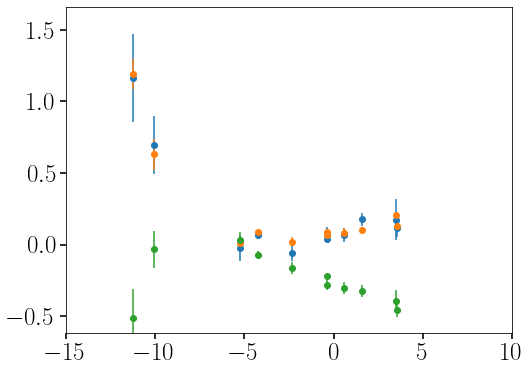

In [58]:
plt.figure(figsize=(8, 6))
plt.errorbar((joj_UCB["MJD"] - 59722.77)/(1+z), joj_UCB["B"] - joj_UCB["V"] - ebv, yerr=joj_UCB["EB"].values, fmt="o")
plt.errorbar((joj_UCB["MJD"] - 59722.77)/(1+z), joj_UCB["B"] - joj_UCB["R"], yerr=joj_UCB["EV"].values, fmt="o")
plt.errorbar((joj_UCB["MJD"] - 59722.77)/(1+z), joj_UCB["R"] - joj_UCB["I"], yerr=joj_UCB["EI"].values, fmt="o")
plt.xlim(-15, 10)
# plt.ylim(-0.2, 0.2)

In [15]:
leff_B = 4354.45  # AA
leff_V = 5336.14  # AA
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
leff_uvot_u = 3523.78
leff_uvot_b = 4345.96
leff_uvot_v = 5412.38
leff_atlas_o = 6629.82
rv = 3.1
ebv = 0.032

## Color evolution

In [16]:
# From Bulla, Miller+2020

gr_population = pd.read_csv(
    "color/g_r_Bulla20.txt",
    delim_whitespace=True,
    comment="#",
    names=[
        "SN",
        "t",
        "e_t_min",
        "e_t_max",
        "gr",
        "e_gr_min",
        "e_gr_max",
        "type",
        "marker",
    ],
)

normal_ia = np.where(
    (gr_population.type == "normal*") | (gr_population.type == "normal")
)
over_luminous_ia = np.where(
    (gr_population.type == "91T-like")
    | (gr_population.type == "99aa-like")
    | (gr_population.type == "99aa-like*")
)

print(
    "There are {} normal SNe in this sample".format(
        len(gr_population.iloc[normal_ia].SN.unique())
    )
)

There are 56 normal SNe in this sample


In [17]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude/flux
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    if not flux:
        mag1, mag2 = X[:, 1], Y[:, 1]
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        f1, f2 = X[:, 1], Y[:, 1]
        f_unc1, f_unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    if f1[i] <= f_unc1[i] or f2[j] <= f_unc2[j]:
                        j += 1
                        continue
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [59]:
t_max_mjd_B = 59722.77

# SN 2022joj
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
rv = 3.1
ebv = 0.032

t_fl_mjd = 59703.158
t_fl_mjd_lo, t_fl_mjd_up = 59702.583, 59703.855

rise_time = (t_max_mjd_B - t_fl_mjd) / (1 + z)

t_exp = -(t_max_mjd_B - t_fl_mjd) / (1 + z)
t_exp_lo = -(t_max_mjd_B - t_fl_mjd_lo) / (1 + z)
t_exp_up = -(t_max_mjd_B - t_fl_mjd_up) / (1 + z)

g_r_cor = calALambda(leff_g, EBV=ebv, RV=rv) - calALambda(leff_r, EBV=ebv, RV=rv)
r_i_cor = calALambda(leff_r, EBV=ebv, RV=rv) - calALambda(leff_i, EBV=ebv, RV=rv)

ZTFg = np.array(
    [joj_ZTF_g["phase"], joj_ZTF_g["fnu_microJy"], joj_ZTF_g["fnu_microJy_unc"]]
).T
ZTFr = np.array(
    [joj_ZTF_r["phase"], joj_ZTF_r["fnu_microJy"], joj_ZTF_r["fnu_microJy_unc"]]
).T
ZTFi = np.array(
    [joj_ZTF_i["phase"], joj_ZTF_i["fnu_microJy"], joj_ZTF_i["fnu_microJy_unc"]]
).T

for lc in [ZTFg, ZTFr, ZTFi]:
    idx = lc[:, 1] < lc[:, 2] * 2
    lc[idx, 1] = lc[idx, 2] * 3
    lc[idx, 2] = 9999

phase_joj, g_r_joj, g_r_unc_joj = mag1_mag2(ZTFg, ZTFr, flux=True, bin_size=0.2)
g_r_joj = g_r_joj - g_r_cor
# print(phase_joj)
# K_corr = np.array([-0.1953523,  -0.18842639, -0.18842264, -0.17979563, -0.13118341, -0.07866182,
#  -0.07784923, -0.09957032, -0.14747028, -0.16704749, -0.18622967, -0.23207121,
#  -0.21986836, -0.21986175, -0.19807829, -0.19807533, -0.19169122, -0.18660783,
#  -0.17411484, -0.17234143, -0.16950744, -0.15789981])

In [60]:
# SN2011fe
g_fe = np.loadtxt("./SN2011fe/SN2011fe_g_synthetic.dat")
r_fe = np.loadtxt("./SN2011fe/SN2011fe_r_synthetic.dat")
g_r_fe = np.loadtxt("./SN2011fe/SN2011fe_g_r_synthetic.dat")

t_fl_fe = 55796.687
t_max_mjd_fe = 55814.5

distmod_fe = 29.04

In [61]:
spec_phase = np.array([
    -12.149183974598644,
    -0.3280252297145444,
    2.5050584023454725,
    2.5880499533660646,
    7.301290297593338,
    9.004604033640556,
    19.967742368995108,
    21.597422519860437,
    28.93561030213988,
    36.16479812335048,
    36.509110730417405,
    36.60235360535974,
    46.216726366567194,
    60.46605863572961,
    286.80518026787223,
    329.7670427114186,
])

59701.380034700036 21.297784379266172
59702.26668980019 21.47711895878858
ZTF18abauprj over_luminous


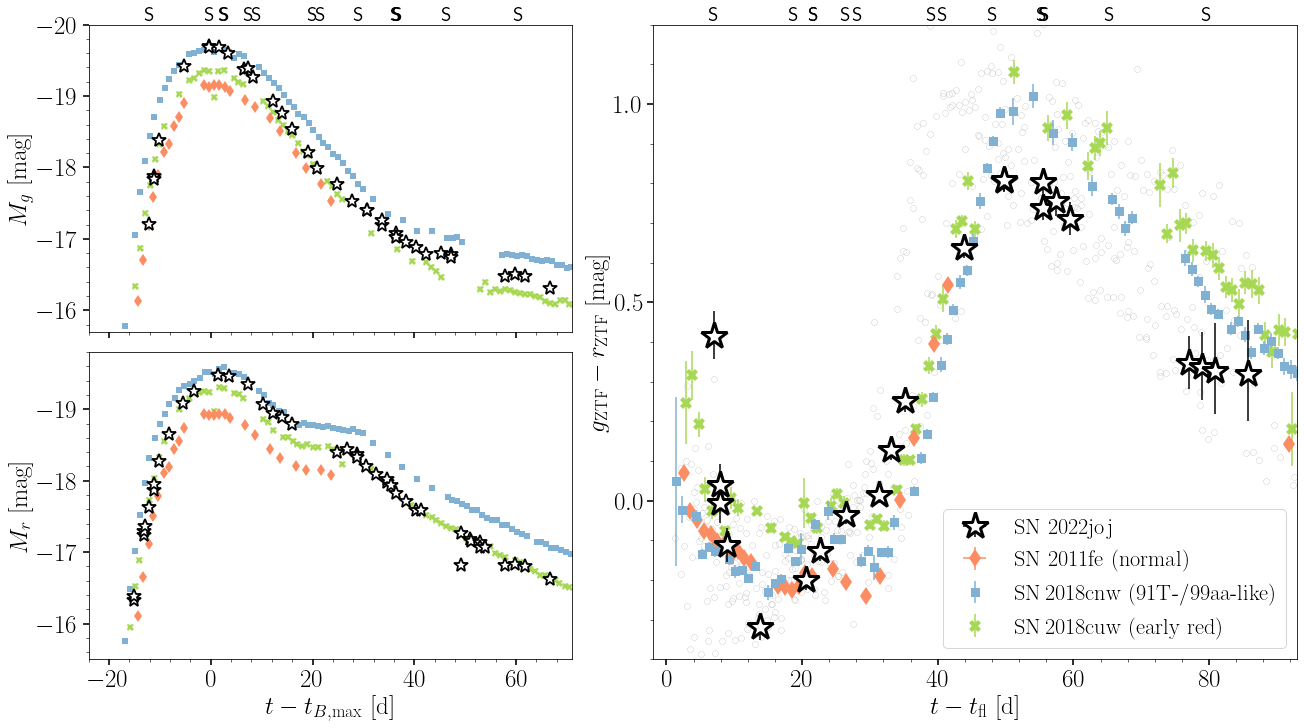

In [62]:
f = plt.figure(figsize=(18, 10), constrained_layout=True)
widths = [6, 8]
heights = [3.5, 3.5]
gs = f.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
# g light curves
ax1 = f.add_subplot(gs[0, 0])
# r light curves
ax2 = f.add_subplot(gs[1, 0])
# g - r
ax3 = f.add_subplot(gs[:, 1])

col_91T = color_map["blue"]
col_13bh = color_map["green1"]
col_11fe = color_map["orange"]

# 11fe
ax1.errorbar(
    (g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    g_fe[:, 1] - distmod_fe,
    yerr=g_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)
ax2.errorbar(
    (r_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    r_fe[:, 1] - distmod_fe,
    yerr=r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)

for x, ax, leff in zip([joj_ZTF_g, joj_ZTF_r], [ax1, ax2], [leff_g, leff_r]):
    # last non-detection
    last_non_det = np.argwhere(
        (x["fnu_microJy"].values <= x["fnu_microJy_unc"].values * 2)
        & (x["phase"].values < -15)
    ).ravel()[-1]
    lim_non_det = -2.5 * np.log10(
        x["fnu_microJy_unc"].values[last_non_det] * 3 * 1e-6 / 3631
    )
    ax.arrow(
        x=x["phase"].values[last_non_det],
        y=lim_non_det - mu - calALambda(leff, RV=rv, EBV=ebv) - 0.3,
        dx=0,
        dy=0.3,
        width=0.08,
        head_width=1,
        head_length=0.1,
        length_includes_head=True,
        color="w",
    )
    print(x["MJD"].values[last_non_det], lim_non_det)
    ax.errorbar(
        x["phase"],
        x["mag"] - mu - calALambda(leff, RV=rv, EBV=ebv),
        yerr=np.array([x["mag_err_l"].values, x["mag_err_u"].values]),
        fmt="*",
        markersize=15,
        markeredgecolor="k",
        markeredgewidth=1.8,
        color="w",
    )

    ax.set_xlim(-24, 71)

ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r"$M_g\ \mathrm{[mag]}$")
ax2.set_ylabel(r"$M_r\ \mathrm{[mag]}$")
ax2.set_xlabel(r"$t-t_{B,\mathrm{max}}\ [\mathrm{d}]$")

ax2.set_ylim(-19.8, -15.5)
ax1.set_ylim(-20, -15.7)
ax1.invert_yaxis()
ax2.invert_yaxis()

# g-r color
# the four individuals
ax3.errorbar(
    phase_joj + rise_time,
    g_r_joj,
    xerr=[[t_fl_mjd_up - t_fl_mjd], [t_fl_mjd - t_fl_mjd_lo]],
    yerr=g_r_unc_joj,
    fmt="*",
    markersize=28,
    markeredgecolor="k",
    markeredgewidth=3,
    color="w",
    ecolor="k",
    zorder=100,
    label="$\mathrm{SN\ 2022joj}$",
)
ax3.errorbar(
    (g_r_fe[:, 0] - t_fl_fe) / (1 + 0.0008),
    g_r_fe[:, 1],
    xerr=np.ones_like(g_r_fe[:, 0]) * 0.014,
    yerr=g_r_fe[:, 2],
    fmt="d",
    markersize=13,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
    label="$\mathrm{SN\ 2011fe\ (normal)}$",
)

# peak time
# ax3.plot([(tp - tfl) / (1 + z), (tp - tfl) / (1 + z)], [-0.7, -0.4],
#          color=col_22joj,
#          alpha=.9,
#          zorder=-10)

# ZTF sample
# K-corrections
# ax3.plot(
#     gr_population.iloc[normal_ia].t.values,
#     gr_population.iloc[normal_ia].gr.values,
#     "o",
#     color="None",
#     mec="0.4",
#     mew=0.3,
#     ms=6,
#     alpha=0.5,
# )
# ax3.plot(
#     gr_population.iloc[over_luminous_ia].t.values,
#     gr_population.iloc[over_luminous_ia].gr.values,
#     "s",
#     color="#80b1d3",
#     mec="k",
#     mew=0.5,
#     ms=6,
#     alpha=.5,
# )


# No K-corrections
ebv_sbv = pd.read_csv("./color/early18ia/ebv_sbv.txt", sep=" ")
lcs = glob.glob("./color/early18ia/*dat")
lcs.sort()
t_tfl_list = fits.getdata("./color/Bulla20.fit")

count = 0
for lc in lcs:
    name = lc.split("/")[-1].split(".")[0]
    if (name in gr_population.iloc[over_luminous_ia].SN.unique()) or (
        name in gr_population.iloc[normal_ia].SN.unique()
    ):
        t_tfl = t_tfl_list["t-tfl"][t_tfl_list["ZTF"] == name]
        if t_tfl_list["z"][t_tfl_list["ZTF"] == name] > 0.05:
            continue
        count += 1
        raw = pd.read_csv(lc, sep=" ")
        lc_g0 = np.array(raw)[:, :-1][raw["fid"] == 1]  # determine the first detection
        lc_r0 = np.array(raw)[:, :-1][raw["fid"] == 2]
        lc_g = np.array(raw)[:, :-1][
            (raw["fid"] == 1) & (raw["mag_unc"] < 0.2)
        ]  # SNR > 5
        lc_r = np.array(raw)[:, :-1][(raw["fid"] == 2) & (raw["mag_unc"] < 0.2)]
        g_r0 = mag1_mag2(lc_g0, lc_r0, bin_size=0.3)
        g_r = mag1_mag2(lc_g, lc_r, bin_size=0.3)
        t_offset = t_tfl - g_r0[0][0]
        ebv_obj = np.array(ebv_sbv["ebv"])[ebv_sbv["sn"] == name][0]
        if name == "ZTF18abcflnz":
            ax1.plot(
                lc_g0[:, 0],
                lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                "X",
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=7,
            )
            ax2.plot(
                lc_r0[:, 0],
                lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                "X",
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=7,
            )
            ax3.errorbar(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                fmt="X",
                yerr=g_r[2],
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=12,
                label=r"$\mathrm{SN\,2018cuw\ (early\ red)}$",
                zorder=-1,
            )
        if name == "ZTF18abauprj":
            print(name, "over_luminous")
            ax1.plot(
                lc_g0[:, 0],
                lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax2.plot(
                lc_r0[:, 0],
                lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax3.errorbar(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                fmt="s",
                yerr=g_r[2],
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=9,
                label=r"$\mathrm{SN\,2018cnw\ (91T}$-/$\mathrm{99aa}$-$\mathrm{like)}$"
                # label=r"$\mathrm{" + name + r"\ (91T}$-$\mathrm{like)}$",
            )
        else:
            ax3.plot(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                "o",
                color="None",
                mec="0.7",
                mew=0.3,
                ms=6,
                zorder=-10,
            )

# ax3.errorbar(
#     g_r_bh[0] + (t_max_mjd_bh - t_fl_bh) / (1 + z),
#     g_r_bh[1],
#     xerr=np.ones_like(g_r_bh[0]) * 2.5,
#     yerr=g_r_bh[2],
#     fmt="p",
#     markersize=15,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
#     label=r"$\mathrm{SN\ 2013bh\ (00cx}$-$\mathrm{like)}$",
# )
ax3.set_ylim(-0.4, 1.2)
ax3.set_xlim(-2, 93)
ax3.set_ylabel("$g_\mathrm{ZTF}-r_\mathrm{ZTF}\ \mathrm{[mag]}$")
ax3.set_xlabel("$t-t_\mathrm{fl}\ [\mathrm{d}]$")
# ax3.set_xscale("log")
ax3.legend(prop={"size": 22.5})

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(4))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3.xaxis.set_major_locator(MultipleLocator(20))
ax3.xaxis.set_minor_locator(MultipleLocator(4))
ax3.yaxis.set_major_locator(MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

# xticks = [1, 2, 5, 10, 20, 40, 60, 100]
# ax3.set_xticks(xticks)
# ax3.set_xticklabels([f"${tick}$" for tick in xticks])

for phase in spec_phase[spec_phase < 100]:
    # ax1.plot([phase, phase], [ax1.get_ylim()[-1] + 0.2, ax1.get_ylim()[-1]], color='0.7', lw=3)
    # ax2.plot([phase, phase], [ax2.get_ylim()[-1] + 0.2, ax2.get_ylim()[-1]], color='0.7', lw=3)
    # ax3.plot([phase + rise_time, phase + rise_time], [ax3.get_ylim()[-1] - 0.05, ax3.get_ylim()[-1]], color='0.7', lw=3)
    ax1.text(
        x=phase, y=ax1.get_ylim()[-1], ha="center", va="bottom", s=r"S", fontsize=20
    )
    ax3.text(
        x=phase + rise_time,
        y=ax3.get_ylim()[-1],
        ha="center",
        va="bottom",
        s=r"S",
        fontsize=20,
    )

plt.savefig("../paper/figures/photometry.pdf", bbox_inches="tight")

59701.380034700036 21.297784379266172
59702.26668980019 21.47711895878858
ZTF18abauprj over_luminous


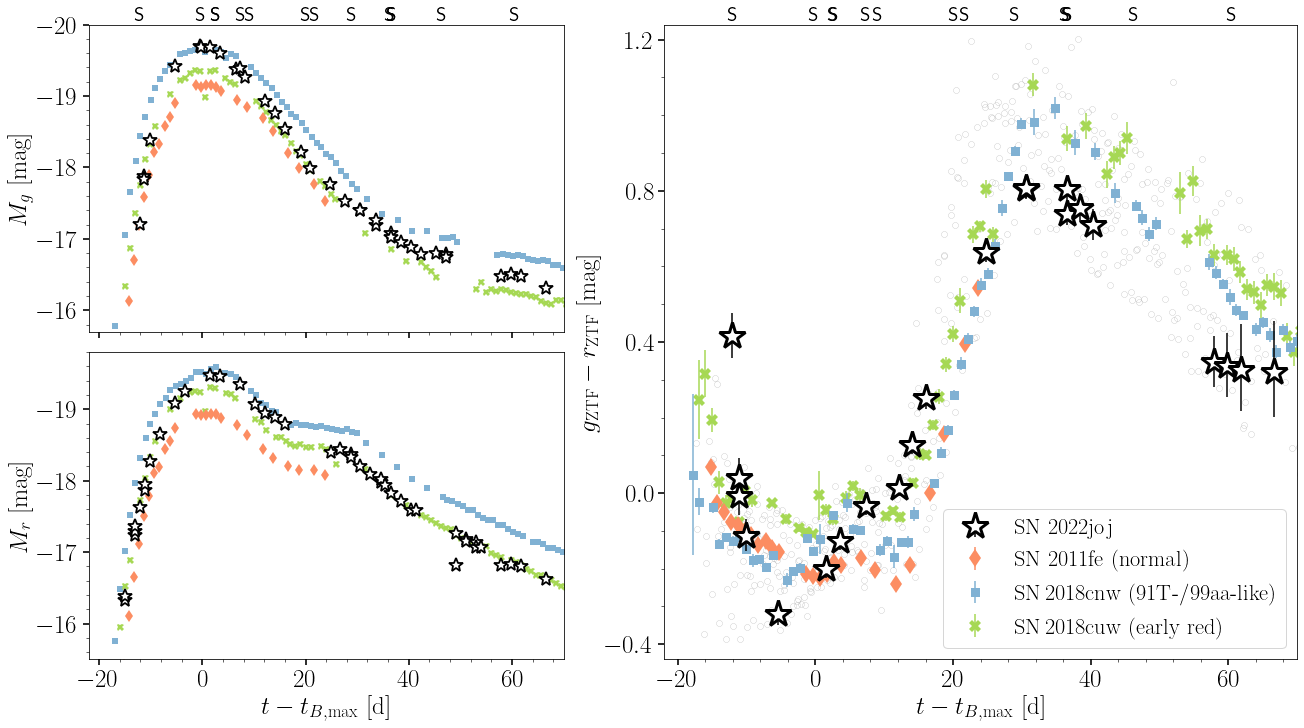

In [63]:
f = plt.figure(figsize=(18, 10), constrained_layout=True)
widths = [6, 8]
heights = [3.5, 3.5]
gs = f.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
# g light curves
ax1 = f.add_subplot(gs[0, 0])
# r light curves
ax2 = f.add_subplot(gs[1, 0])
# g - r
ax3 = f.add_subplot(gs[:, 1])

col_91T = color_map["blue"]
col_13bh = color_map["green1"]
col_11fe = color_map["orange"]

# 11fe
ax1.errorbar(
    (g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    g_fe[:, 1] - distmod_fe,
    yerr=g_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)
ax2.errorbar(
    (r_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    r_fe[:, 1] - distmod_fe,
    yerr=r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)

for x, ax, leff in zip([joj_ZTF_g, joj_ZTF_r], [ax1, ax2], [leff_g, leff_r]):
    # last non-detection
    last_non_det = np.argwhere(
        (x["fnu_microJy"].values <= x["fnu_microJy_unc"].values * 2)
        & (x["phase"].values < -15)
    ).ravel()[-1]
    lim_non_det = -2.5 * np.log10(
        x["fnu_microJy_unc"].values[last_non_det] * 3 * 1e-6 / 3631
    )
    # ax.arrow(
    #     x=x["phase"].values[last_non_det],
    #     y=lim_non_det - mu - calALambda(leff, RV=rv, EBV=ebv) - 0.3,
    #     dx=0,
    #     dy=0.3,
    #     width=0.08,
    #     head_width=1,
    #     head_length=0.1,
    #     length_includes_head=True,
    #     color="w",
    # )
    print(x["MJD"].values[last_non_det], lim_non_det)
    ax.errorbar(
        x["phase"],
        x["mag"] - mu - calALambda(leff, RV=rv, EBV=ebv),
        yerr=np.array([x["mag_err_l"].values, x["mag_err_u"].values]),
        fmt="*",
        markersize=15,
        markeredgecolor="k",
        markeredgewidth=1.8,
        color="w",
    )

    ax.set_xlim(-22, 70)

ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r"$M_g\ \mathrm{[mag]}$")
ax2.set_ylabel(r"$M_r\ \mathrm{[mag]}$")
ax2.set_xlabel(r"$t-t_{B,\mathrm{max}}\ [\mathrm{d}]$")

ax2.set_ylim(-19.8, -15.5)
ax1.set_ylim(-20, -15.7)
ax1.invert_yaxis()
ax2.invert_yaxis()

# g-r color
# the four individuals
ax3.errorbar(
    phase_joj,
    g_r_joj,
    # xerr=[[t_fl_mjd_up - t_fl_mjd], [t_fl_mjd - t_fl_mjd_lo]],
    yerr=g_r_unc_joj,
    fmt="*",
    markersize=28,
    markeredgecolor="k",
    markeredgewidth=3,
    color="w",
    ecolor="k",
    zorder=100,
    label="$\mathrm{SN\ 2022joj}$",
)
ax3.errorbar(
    (g_r_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    g_r_fe[:, 1],
    # xerr=np.ones_like(g_r_fe[:, 0]) * 0.014,
    yerr=g_r_fe[:, 2],
    fmt="d",
    markersize=13,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
    label="$\mathrm{SN\ 2011fe\ (normal)}$",
)

# peak time
# ax3.plot([(tp - tfl) / (1 + z), (tp - tfl) / (1 + z)], [-0.7, -0.4],
#          color=col_22joj,
#          alpha=.9,
#          zorder=-10)

# ZTF sample
# K-corrections
# ax3.plot(
#     gr_population.iloc[normal_ia].t.values,
#     gr_population.iloc[normal_ia].gr.values,
#     "o",
#     color="None",
#     mec="0.4",
#     mew=0.3,
#     ms=6,
#     alpha=0.5,
# )
# ax3.plot(
#     gr_population.iloc[over_luminous_ia].t.values,
#     gr_population.iloc[over_luminous_ia].gr.values,
#     "s",
#     color="#80b1d3",
#     mec="k",
#     mew=0.5,
#     ms=6,
#     alpha=.5,
# )


# No K-corrections
ebv_sbv = pd.read_csv("./color/early18ia/ebv_sbv.txt", sep=" ")
lcs = glob.glob("./color/early18ia/*dat")
lcs.sort()
t_tfl_list = fits.getdata("./color/Bulla20.fit")

count = 0
for lc in lcs:
    name = lc.split("/")[-1].split(".")[0]
    if (name in gr_population.iloc[over_luminous_ia].SN.unique()) or (
        name in gr_population.iloc[normal_ia].SN.unique()
    ):
        t_tfl = t_tfl_list["t-tfl"][t_tfl_list["ZTF"] == name]
        if t_tfl_list["z"][t_tfl_list["ZTF"] == name] > 0.05:
            continue
        count += 1
        raw = pd.read_csv(lc, sep=" ")
        lc_g0 = np.array(raw)[:, :-1][raw["fid"] == 1]  # determine the first detection
        lc_r0 = np.array(raw)[:, :-1][raw["fid"] == 2]
        lc_g = np.array(raw)[:, :-1][
            (raw["fid"] == 1) & (raw["mag_unc"] < 0.2)
        ]  # SNR > 5
        lc_r = np.array(raw)[:, :-1][(raw["fid"] == 2) & (raw["mag_unc"] < 0.2)]
        g_r0 = mag1_mag2(lc_g0, lc_r0, bin_size=0.3)
        g_r = mag1_mag2(lc_g, lc_r, bin_size=0.3)
        t_offset = t_tfl - g_r0[0][0]
        ebv_obj = np.array(ebv_sbv["ebv"])[ebv_sbv["sn"] == name][0]
        if name == "ZTF18abcflnz":
            ax1.plot(
                lc_g0[:, 0],
                lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                "X",
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=7,
            )
            ax2.plot(
                lc_r0[:, 0],
                lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                "X",
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=7,
            )
            ax3.errorbar(
                g_r[0],
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                fmt="X",
                yerr=g_r[2],
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=12,
                label=r"$\mathrm{SN\,2018cuw\ (early\ red)}$",
                zorder=-1,
            )
        if name == "ZTF18abauprj":
            print(name, "over_luminous")
            ax1.plot(
                lc_g0[:, 0],
                lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax2.plot(
                lc_r0[:, 0],
                lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax3.errorbar(
                g_r[0],
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                fmt="s",
                yerr=g_r[2],
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=9,
                label=r"$\mathrm{SN\,2018cnw\ (91T}$-/$\mathrm{99aa}$-$\mathrm{like)}$"
                # label=r"$\mathrm{" + name + r"\ (91T}$-$\mathrm{like)}$",
            )
        else:
            ax3.plot(
                g_r[0],
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                "o",
                color="None",
                mec="0.7",
                mew=0.3,
                ms=6,
                zorder=-10,
            )

# ax3.errorbar(
#     g_r_bh[0] + (t_max_mjd_bh - t_fl_bh) / (1 + z),
#     g_r_bh[1],
#     xerr=np.ones_like(g_r_bh[0]) * 2.5,
#     yerr=g_r_bh[2],
#     fmt="p",
#     markersize=15,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
#     label=r"$\mathrm{SN\ 2013bh\ (00cx}$-$\mathrm{like)}$",
# )
ax3.set_ylim(-0.44, 1.24)
ax3.set_xlim(-22, 70)
ax3.set_ylabel("$g_\mathrm{ZTF}-r_\mathrm{ZTF}\ \mathrm{[mag]}$")
ax3.set_xlabel("$t-t_{B, \mathrm{max}}\ \mathrm{[d]}$")
# ax3.set_xscale("log")
ax3.legend(prop={"size": 22.5})

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(4))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3.xaxis.set_major_locator(MultipleLocator(20))
ax3.xaxis.set_minor_locator(MultipleLocator(4))
ax3.yaxis.set_major_locator(MultipleLocator(0.4))
ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

# xticks = [1, 2, 5, 10, 20, 40, 60, 100]
# ax3.set_xticks(xticks)
# ax3.set_xticklabels([f"${tick}$" for tick in xticks])

for phase in spec_phase[spec_phase < 100]:
    # ax1.plot([phase, phase], [ax1.get_ylim()[-1] + 0.2, ax1.get_ylim()[-1]], color='0.7', lw=3)
    # ax2.plot([phase, phase], [ax2.get_ylim()[-1] + 0.2, ax2.get_ylim()[-1]], color='0.7', lw=3)
    # ax3.plot([phase + rise_time, phase + rise_time], [ax3.get_ylim()[-1] - 0.05, ax3.get_ylim()[-1]], color='0.7', lw=3)
    ax1.text(
        x=phase, y=ax1.get_ylim()[-1], ha="center", va="bottom", s=r"S", fontsize=20
    )
    ax3.text(
        x=phase,
        y=ax3.get_ylim()[-1],
        ha="center",
        va="bottom",
        s=r"S",
        fontsize=20,
    )

# for ax in [ax1, ax2, ax3]:
#     ax.fill_between([-rise_time-0.58, -rise_time+0.70], [ax.get_ylim()[0]]*2, [ax.get_ylim()[1]]*2, color="0.5", alpha=0.5)

plt.savefig("../paper/figures/photometry.pdf", bbox_inches="tight")

In [55]:
phase_joj, joj_ZTF_g["phase"]

(array([-12.13963459, -11.16644672, -11.16596305, -10.13258685,
         -5.36569977,   1.50567345,   3.50872845,   7.330484  ,
         12.18663515,  14.08886492,  16.05061398,  24.84914661,
         30.62303309,  30.62496066,  36.4855189 ,  36.48634176,
         38.42048435,  40.39012198,  57.8841388 ,  59.86469453,
         61.80241651,  66.62753596]),
 986    -24.786246
 991    -22.687330
 992    -22.686418
 994    -21.814791
 995    -20.863684
 996    -20.862760
 997    -20.802690
 998    -20.800854
 1006   -12.123036
 1007   -11.207878
 1008   -11.206965
 1011   -10.183734
 1015    -5.273134
 1018    -0.423280
 1019    -0.340397
 1022     1.525226
 1023     3.471298
 1026     6.448770
 1028     7.345520
 1030     8.340000
 1034    12.190361
 1035    14.056615
 1038    16.002304
 1041    19.068675
 1043    20.920745
 1045    24.822894
 1048    27.705643
 1053    30.644078
 1054    30.645002
 1057    33.564218
 1058    33.604989
 1062    36.466208
 1063    36.467132
 1066    38.405

Text(0.5, 1.0, '$r$')

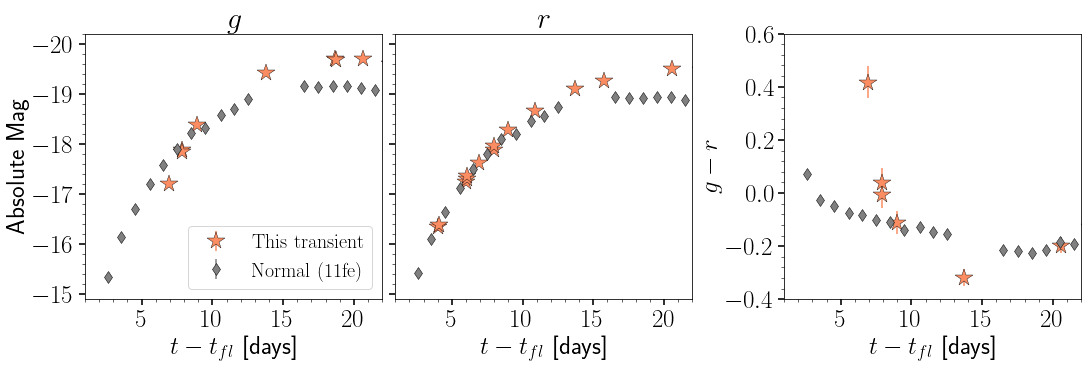

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, sharex=True)

col_22joj = color_map["orange"]

for x, a, leff in zip([joj_ZTF_g, joj_ZTF_r], ax, [leff_g, leff_r]):
    a.errorbar(
        x["phase"] + rise_time,
        x["mag"] - mu - calALambda(leff, RV=rv, EBV=ebv),
        # xerr=[[t_fl_mjd_up - t_fl_mjd], [t_fl_mjd - t_fl_mjd_lo]],
        yerr=np.array([x["mag_err_l"].values, x["mag_err_u"].values]),
        fmt="*",
        markersize=18,
        markeredgecolor="k",
        markeredgewidth=0.4,
        color=col_22joj,
        label="$\mathrm{This\ transient}$",
    )
    a.set_ylim(-14.9, -20.2)

    a.xaxis.set_major_locator(MultipleLocator(5))
    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.yaxis.set_major_locator(MultipleLocator(1))
    a.yaxis.set_minor_locator(MultipleLocator(0.2))

ax[1].set_yticklabels([])
ax[2].set_ylabel(r"$g-r$")
ax[2].errorbar(
    phase_joj + rise_time,
    g_r_joj,
    yerr=g_r_unc_joj,
    fmt="*",
    markersize=18,
    markeredgecolor="k",
    markeredgewidth=0.4,
    color=col_22joj,
)


ax[0].errorbar(
    (g_fe[:, 0] - t_fl_fe) / (1 + 0.0008),
    g_fe[:, 1] - distmod_fe,
    yerr=g_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color="0.5",
    label="$\mathrm{Normal\ (11fe)}$",
)
ax[1].errorbar(
    (r_fe[:, 0] - t_fl_fe) / (1 + 0.000804),
    r_fe[:, 1] - distmod_fe,
    yerr=r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color="0.5",
)
ax[2].errorbar(
    (g_r_fe[:, 0] - t_fl_fe) / (1 + 0.000804),
    g_r_fe[:, 1],
    yerr=g_r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color="0.5",
)
ax[0].set_xlim(1, 22)
ax[0].legend(prop={"size": 20})


ax[2].set_ylim(-0.4, 0.6)
ax[2].yaxis.set_major_locator(MultipleLocator(0.2))
ax[2].yaxis.set_minor_locator(MultipleLocator(0.04))

ax[0].set_xlabel(r"$t - t_{fl}$ [days]")
ax[1].set_xlabel(r"$t - t_{fl}$ [days]")
ax[2].set_xlabel(r"$t - t_{fl}$ [days]")
ax[0].set_ylabel(r"Absolute Mag")

ax[0].set_title("$g$")
ax[1].set_title("$r$")

In [24]:
def syn_color(wv, F_mean, flt1, flt2):

    flt1, flt2 = np.loadtxt(flt1), np.loadtxt(flt2)

    f0_1 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt1)[0]
    f0_2 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt2)[0]
    color = -2.5 * np.log10(f0_1 / f0_2)

    return color

In [25]:
def K_corr(z, wv, F_mean, flt1, flt2):
    """
    Calculate the synthetic K-correction as a function of z
    """

    flt1, flt2 = np.loadtxt(flt1), np.loadtxt(flt2)

    f0_1 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt1)[0]
    f0_2 = spec_to_flux(spec=[wv, F_mean, np.ones_like(wv, dtype=float)], flt=flt2)[0]
    f_ratio_z_1 = (
        f0_1
        / spec_to_flux(
            spec=[
                wv * (1 + z),
                F_mean / (1 + z),
                np.ones_like(wv, dtype=float),
            ],
            flt=flt1,
        )[0]
    )
    f_ratio_z_2 = (
        f0_2
        / spec_to_flux(
            spec=[
                wv * (1 + z),
                F_mean / (1 + z),
                np.ones_like(wv, dtype=float),
            ],
            flt=flt2,
        )[0]
    )
    # K-corr in single bands
    K_corrs_1 = -2.5 * np.log10(f_ratio_z_1)
    K_corrs_2 = -2.5 * np.log10(f_ratio_z_2)
    # K-corr in the flt1 - flt2 color
    K_corrs_12 = K_corrs_1 - K_corrs_2

    return K_corrs_1, K_corrs_2, K_corrs_12

In [26]:
dat1 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220523_Kast.flm")
dat2 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt")

In [27]:
K_corr(z=z, wv=dat1[:, 0]/(1 + z), F_mean=dat1[:, 1] * (1 + z), flt1="./filters/P48_g.dat", flt2="./filters/P48_R.dat")

(0.029220044659069633, 0.08046314105191979, -0.05124309639285016)

In [28]:
K_corr(z=z, wv=dat2[:, 0]/(1 + z), F_mean=dat2[:, 1] * (1 + z), flt1="./filters/P48_g.dat", flt2="./filters/P48_R.dat")

(0.02133212499625583, 0.08957867496152948, -0.06824654996527366)